# School Dropout Risk Prediction: Model Selection and Interpretability with SHAP

This notebook presents the modeling, evaluation, and interpretability of machine learning models
to predict school dropout risk, with a focus on selecting robust models and interpreting their
predictions using SHAP values.


## 1. Environment Setup and Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import joblib

## 2. Data Loading

In [3]:
# Définir le chemin d'accès
file_path = r"C:\Users\htouy\OneDrive - HEC Montréal\Bureau\HEC\Session Automne 2024\Apprentissage-automatique 1\Projets\Dropout_Data.csv"

# Charger le fichier CSV avec le séparateur ";"
data = pd.read_csv(file_path, sep=';')

## 3. Data Preprocessing

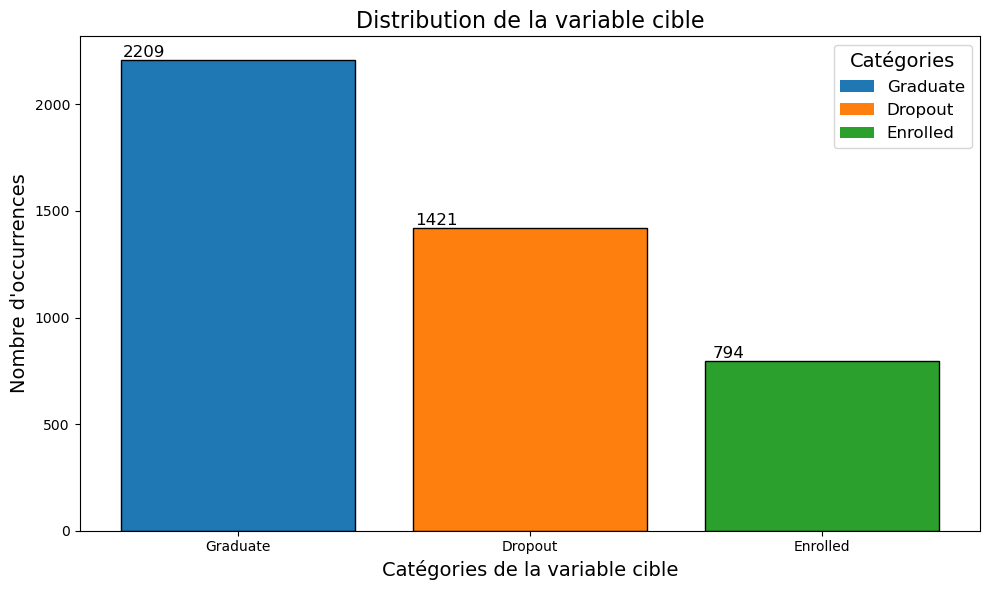

In [7]:

X = data.drop(columns="Target")
y = data["Target"]

# Compter le nombre d'occurrences de chaque classe dans y
target_counts = y.value_counts()

# Définir une palette de couleurs unique pour chaque catégorie
categories = target_counts.index.astype(str)  # Récupérer les catégories
colors = plt.cm.tab10(range(len(categories)))  # Palette avec des couleurs distinctes

# Créer le diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, target_counts.values, color=colors, edgecolor='black', linewidth=1)

# Ajouter des étiquettes et un titre
plt.title('Distribution de la variable cible', fontsize=16)
plt.xlabel('Catégories de la variable cible', fontsize=14)
plt.ylabel('Nombre d\'occurrences', fontsize=14)

# Ajouter les valeurs au-dessus de chaque barre
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 10, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

# Légende indiquant les catégories et leurs couleurs
for i, category in enumerate(categories):
    plt.bar(0, 0, color=colors[i], label=category)  # Barres invisibles pour légende
plt.legend(title="Catégories", fontsize=12, title_fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()


In [31]:
# Séparartion de la base de données en features et target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_original = X_train.copy()  # Sauvegarder les données originales d'entraînement
X_test_original = X_test.copy()    # Sauvegarder les données originales de test
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Appliquer le pipeline sur les données d'entraînement
X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(pipeline.transform(X_test), columns=X_test.columns)


In [11]:
!pip install shap

## 4. Model Training and Evaluation


Meilleurs paramètres des modèles optimaux :
SVM : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
K-Nearest Neighbors : {'n_neighbors': 9, 'weights': 'distance'}
Régression Logistique : {'C': 10, 'solver': 'liblinear'}
Réseau de Neurones : {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.01}


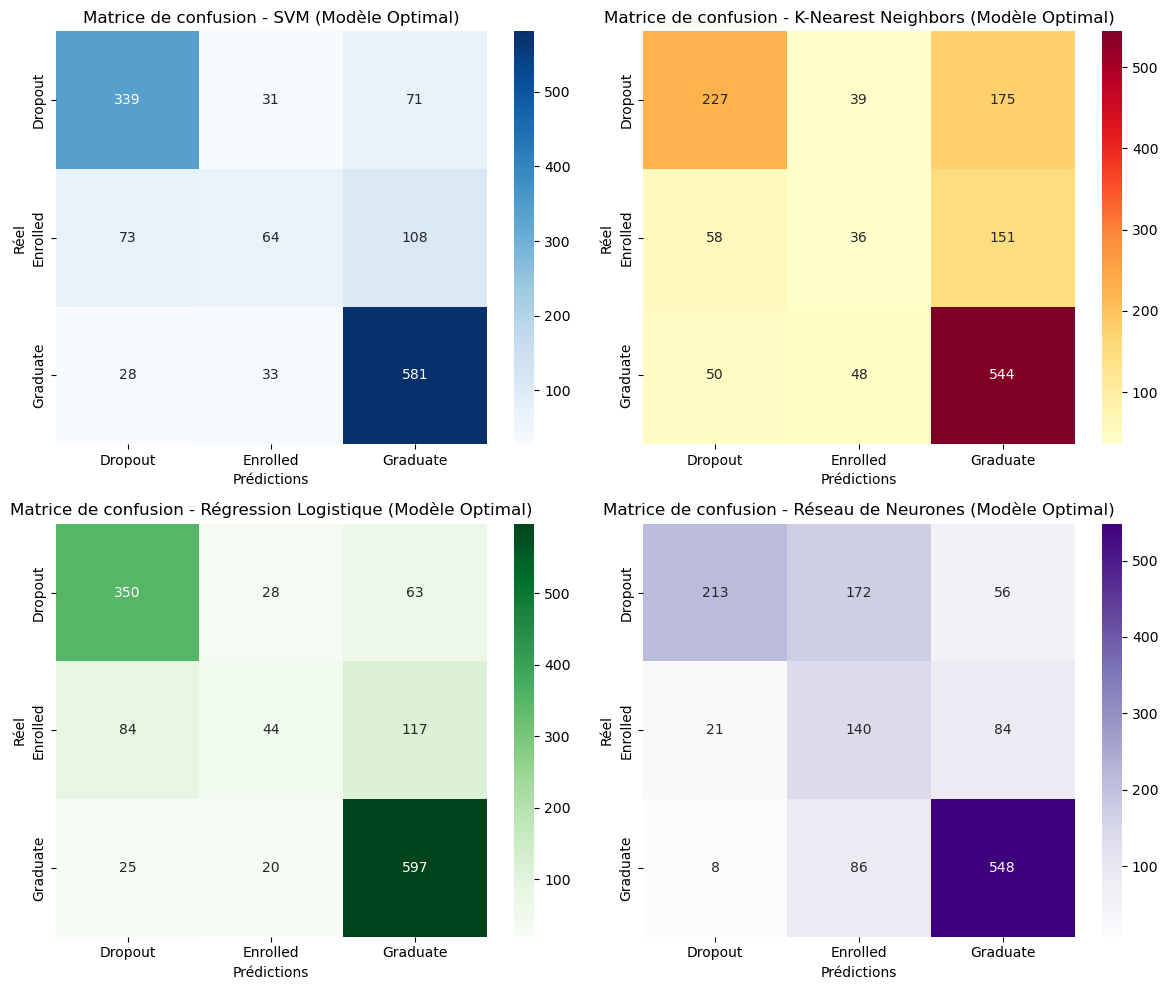


Tableau récapitulatif des performances :
                       Accuracy  Précision    Rappel   F-Score
SVM                    0.740964   0.678309  0.644972  0.647187
K-Nearest Neighbors    0.607681   0.531861  0.503010  0.500093
Régression Logistique  0.746235   0.669709  0.634383  0.626781
Réseau de Neurones     0.678464   0.676145  0.636001  0.627746


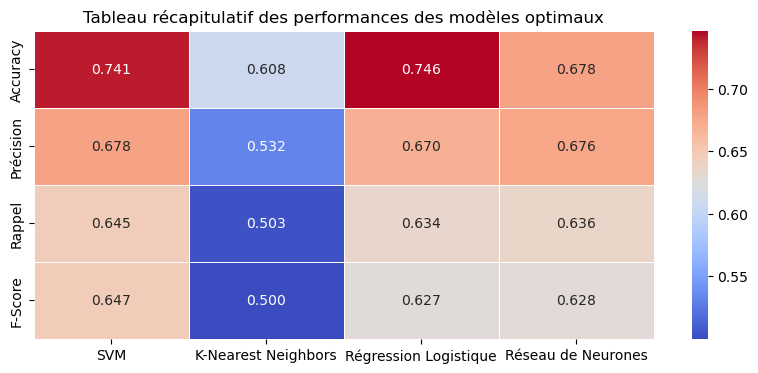


Conclusion :
 - Le meilleur modèle selon l'Accuracy est : Régression Logistique
 - Le meilleur modèle selon la Précision est : SVM
 - Le meilleur modèle selon le Rappel est : SVM
 - Le meilleur modèle selon le F-Score est : SVM



In [11]:

# Définir une fonction pour effectuer le GridSearch et l'évaluation
def grid_search_et_evaluer(modele, param_grid, nom_modele):
    grid_search = GridSearchCV(modele, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Meilleur modèle trouvé et ses paramètres
    meilleur_modele = grid_search.best_estimator_
    meilleurs_parametres = grid_search.best_params_
    y_pred = meilleur_modele.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    fscore = f1_score(y_test, y_pred, average='macro')
    
    # Enregistrer le modèle optimal
    joblib.dump(meilleur_modele, f'{nom_modele}_optimal.pkl')
    
    return meilleur_modele, meilleurs_parametres, accuracy, precision, recall, fscore, y_pred

# Initialiser les modèles et leurs grilles de paramètres
n_neighbors_range = list(range(2, 50))
models_params = [
    (SVC(probability=True), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}, 'SVM'),
    (KNeighborsClassifier(), {'n_neighbors': n_neighbors_range, 'weights': ['uniform', 'distance']}, 'K-Nearest Neighbors'),
    (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}, 'Régression Logistique'),
    (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(64,), (128,), (256,), (64, 64), (128, 128)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01], 
        'learning_rate_init': [0.001, 0.01, 0.1]
    }, 'Réseau de Neurones')
]

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Appliquer le GridSearch pour chaque modèle et stocker les résultats
results = {}
for model, param_grid, nom in models_params:
    model_optimal, meilleurs_parametres, accuracy, precision, recall, fscore, y_pred = grid_search_et_evaluer(model, param_grid, nom)
    results[nom] = {
        'meilleurs_parametres': meilleurs_parametres,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fscore': fscore,
        'y_pred': y_pred
    }

# Afficher les meilleurs paramètres pour chaque modèle
print("\nMeilleurs paramètres des modèles optimaux :")
for nom, result in results.items():
    print(f"{nom} : {result['meilleurs_parametres']}")

# Construire les matrices de confusion avec des palettes différentes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
cmap_list = ['Blues', 'YlOrRd', 'Greens', 'Purples']

for i, (nom, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_list[i], ax=axes[i], xticklabels=np.unique(y), yticklabels=np.unique(y))
    axes[i].set_title(f'Matrice de confusion - {nom} (Modèle Optimal)')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Réel')

plt.tight_layout()
plt.show()

# Créer un tableau récapitulatif des performances
performance_table = pd.DataFrame({
    'Accuracy': [results[nom]['accuracy'] for nom in results],
    'Précision': [results[nom]['precision'] for nom in results],
    'Rappel': [results[nom]['recall'] for nom in results],
    'F-Score': [results[nom]['fscore'] for nom in results]
}, index=results.keys())

print("\nTableau récapitulatif des performances :")
print(performance_table)

# Afficher le tableau récapitulatif des performances
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(performance_table.T, annot=True, fmt='.3f', cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Tableau récapitulatif des performances des modèles optimaux')
plt.show()

# Identifier le meilleur modèle pour chaque mesure de performance
meilleur_accuracy = performance_table['Accuracy'].idxmax()
meilleur_precision = performance_table['Précision'].idxmax()
meilleur_rappel = performance_table['Rappel'].idxmax()
meilleur_fscore = performance_table['F-Score'].idxmax()

# Afficher la conclusion
conclusion = (
    f"\nConclusion :\n"
    f" - Le meilleur modèle selon l'Accuracy est : {meilleur_accuracy}\n"
    f" - Le meilleur modèle selon la Précision est : {meilleur_precision}\n"
    f" - Le meilleur modèle selon le Rappel est : {meilleur_rappel}\n"
    f" - Le meilleur modèle selon le F-Score est : {meilleur_fscore}\n"
)

print(conclusion)


## Model Interpretability with SHAP

Calcul des valeurs SHAP pour le modèle SVM optimal...


PermutationExplainer explainer: 1329it [24:56,  1.13s/it]                          


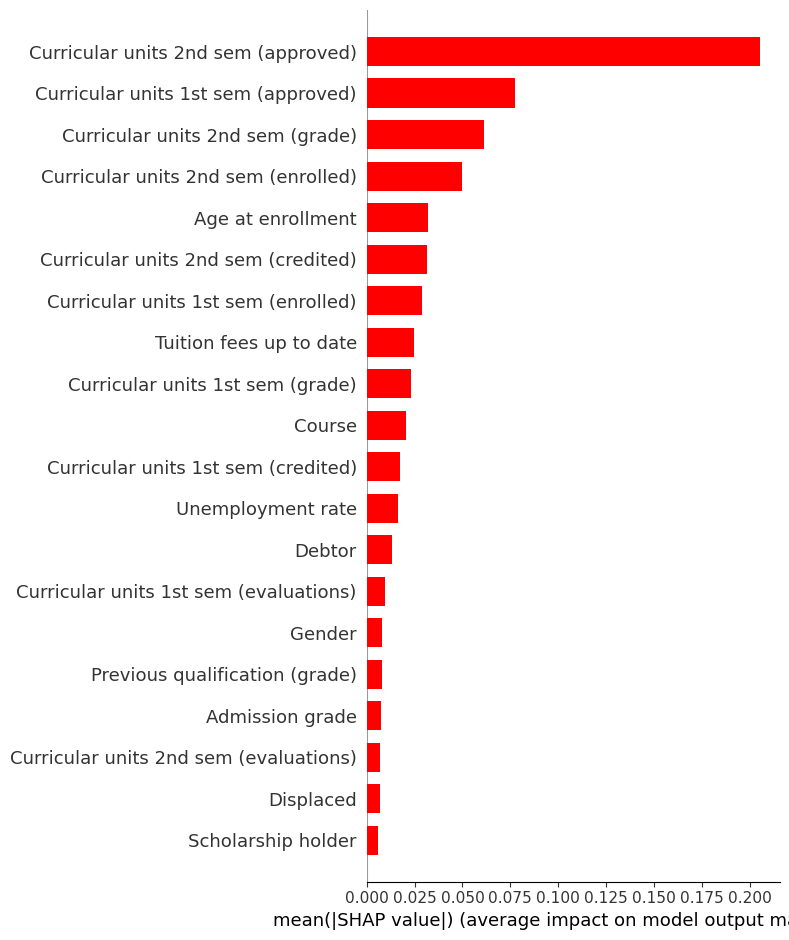

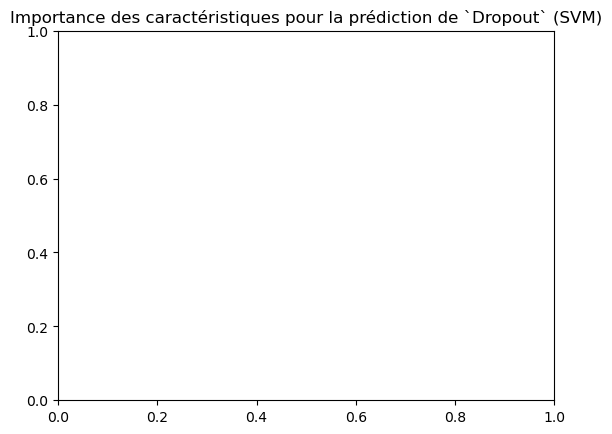


Tableau récapitulatif de l'influence des caractéristiques :
                        Caractéristique  Importance pour Dropout
30  Curricular units 2nd sem (approved)                 0.205399
24  Curricular units 1st sem (approved)                 0.077448
31     Curricular units 2nd sem (grade)                 0.061059
28  Curricular units 2nd sem (enrolled)                 0.049794
19                    Age at enrollment                 0.031828
27  Curricular units 2nd sem (credited)                 0.031285
22  Curricular units 1st sem (enrolled)                 0.028848
16              Tuition fees up to date                 0.024561
25     Curricular units 1st sem (grade)                 0.023226
3                                Course                 0.020551


<Figure size 1200x600 with 0 Axes>

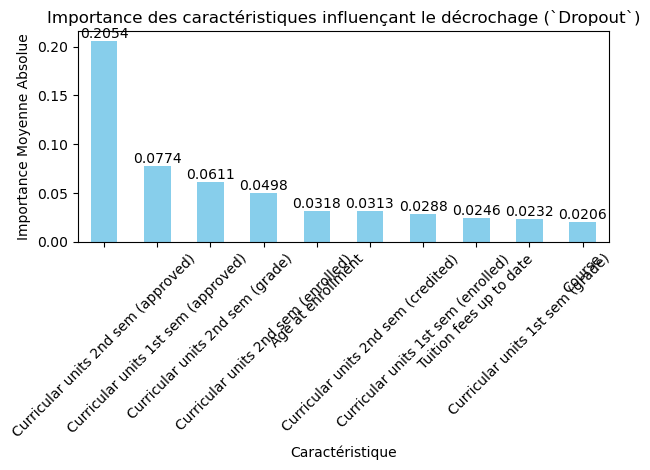


Analyse locale des prédictions pour des cas de Dropout :



Observation 1 (Dropout) :


,1255
Marital status,4.00
Application mode,39.00
Application order,1.00
Course,9130.00
Daytime/evening attendance\t,1.00
Previous qualification,1.00
Previous qualification (grade),133.10
Nacionality,1.00
Mother's qualification,3.00
Father's qualification,1.00


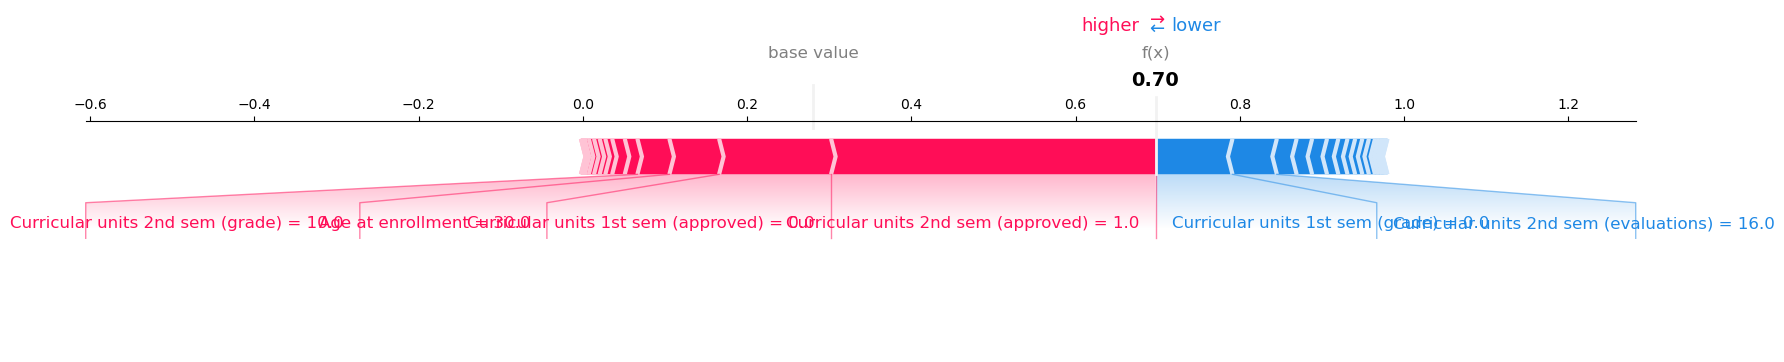


Observation 2 (Dropout) :


,3458
Marital status,1.000000
Application mode,17.000000
Application order,1.000000
Course,9238.000000
Daytime/evening attendance\t,1.000000
Previous qualification,1.000000
Previous qualification (grade),125.000000
Nacionality,1.000000
Mother's qualification,4.000000
Father's qualification,3.000000


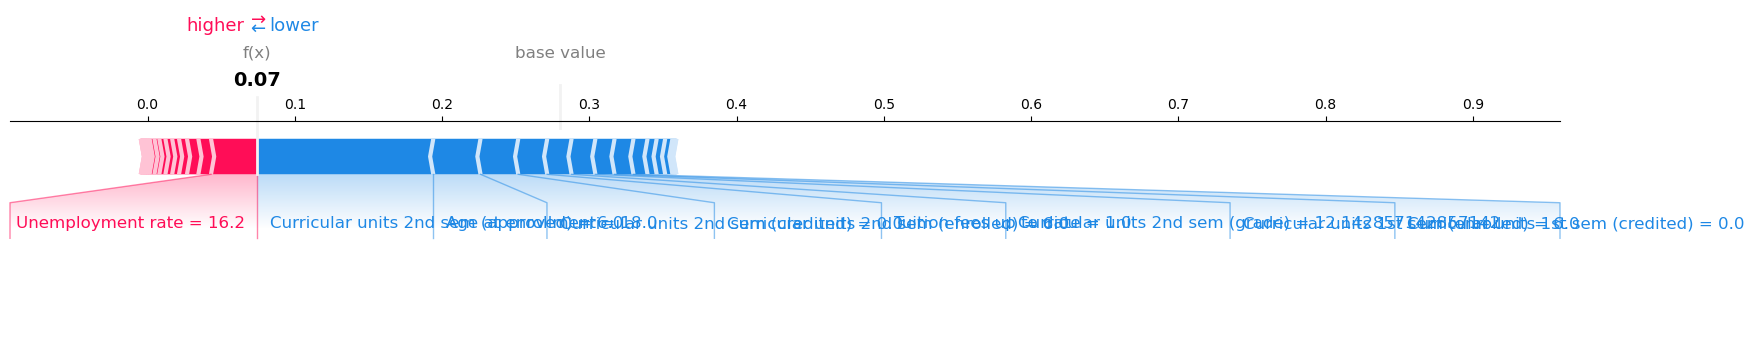


Observation 3 (Dropout) :


,3390
Marital status,1.000000
Application mode,17.000000
Application order,1.000000
Course,9853.000000
Daytime/evening attendance\t,1.000000
Previous qualification,1.000000
Previous qualification (grade),133.000000
Nacionality,1.000000
Mother's qualification,38.000000
Father's qualification,38.000000


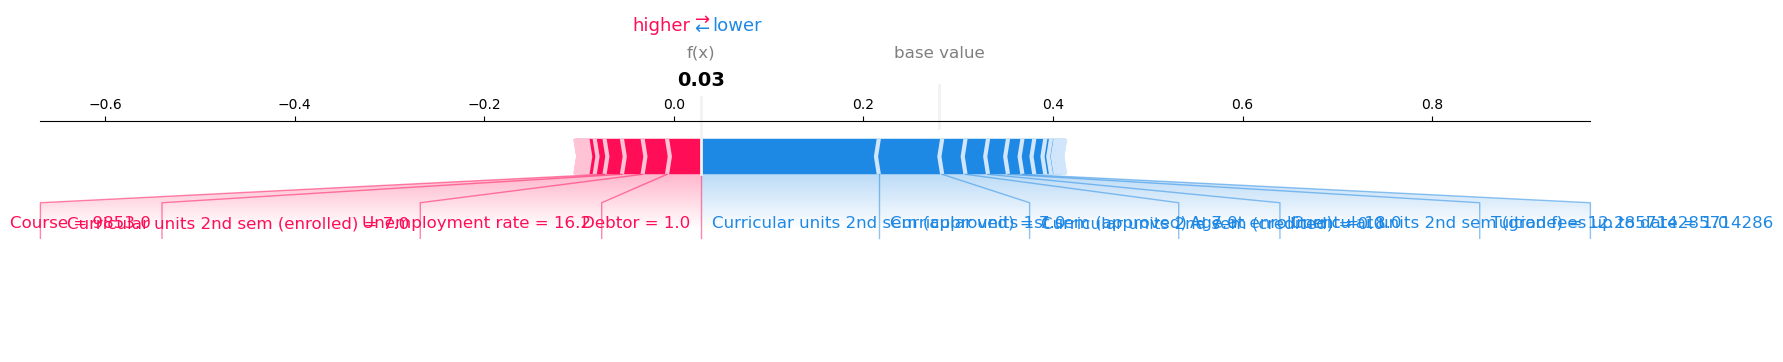


Recommandations basées sur l'analyse des caractéristiques influentes pour `Dropout` :
- Curricular units 2nd sem (approved) est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.
- Curricular units 1st sem (approved) est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.
- Curricular units 2nd sem (grade) est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.
- Curricular units 2nd sem (enrolled) est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.
- Age at enrollment est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.


In [15]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

# Charger le modèle SVM optimal
svm_model_opt = joblib.load("SVM_optimal.pkl")

# Créer l'explainer SHAP pour le modèle SVM
explainer = shap.Explainer(svm_model_opt.predict_proba, X_train)

# Calculer les valeurs SHAP pour tout l'ensemble de test
print("Calcul des valeurs SHAP pour le modèle SVM optimal...")
shap_values = explainer(X_test)

# Extraire les valeurs SHAP pour la classe `Dropout` (indice 0)
dropout_shap_values = shap_values.values[:, :, 0]

# 1. Diagramme d'importance des caractéristiques pour `Dropout`
plt.figure(figsize=(12, 6))
shap.summary_plot(dropout_shap_values, X_test, plot_type="bar", color="red")
plt.title("Importance des caractéristiques pour la prédiction de `Dropout` (SVM)")
plt.show()

# 2. Tableau récapitulatif de l'importance des caractéristiques
dropout_importance = np.mean(np.abs(dropout_shap_values), axis=0)

importance_df = pd.DataFrame({
    "Caractéristique": X_test.columns,
    "Importance pour Dropout": dropout_importance
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by="Importance pour Dropout", ascending=False)

# Afficher le tableau
print("\nTableau récapitulatif de l'influence des caractéristiques :")
print(importance_df.head(10))

# Visualiser l'importance des caractéristiques avec annotations
plt.figure(figsize=(12, 6))
ax = importance_df.head(10).plot(kind="bar", x="Caractéristique", y="Importance pour Dropout", color="skyblue", legend=False)

# Ajouter des annotations au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.xlabel("Caractéristique")
plt.ylabel("Importance Moyenne Absolue")
plt.title("Importance des caractéristiques influençant le décrochage (`Dropout`)")
plt.xticks(rotation=45)
plt.tight_layout()  # Ajuster les marges pour éviter que les étiquettes soient coupées
plt.show()

# 3. Analyse locale des prédictions pour des exemples de `Dropout`
print("\nAnalyse locale des prédictions pour des cas de Dropout :")

# Initialiser JS pour SHAP
shap.initjs()

# Analyse de 3 observations pour la classe `Dropout`
for i in range(3):
    base_value = shap_values.base_values[i, 0]  # Valeur de base pour Dropout (classe 0)
    shap_value = dropout_shap_values[i]         # Valeurs SHAP pour l'observation i (classe Dropout)
    observation = X_test.iloc[i]                # Extraire l'observation i

    # Afficher les détails de l'observation
    print(f"\nObservation {i+1} (Dropout) :")
    display(observation.to_frame())  # Affichage formaté

    # Affichage du force_plot avec Matplotlib
    shap.force_plot(base_value, shap_value, features=observation, feature_names=X_test.columns, matplotlib=True)

# 4. Recommandations basées sur l'analyse des caractéristiques influentes
print("\nRecommandations basées sur l'analyse des caractéristiques influentes pour `Dropout` :")
top_features = importance_df["Caractéristique"][:5].tolist()
for feature in top_features:
    print(f"- {feature} est fortement associée au décrochage. Des mesures spécifiques devraient être mises en place pour améliorer cet aspect.")
